In [14]:
import os
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Input and output directories
input_dir = "./tiffs"
output_dir = "./tiffs_reprojected"

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Target CRS (WGS 1984 UTM Zone 40N)
target_crs = "EPSG:32640"

# Loop through all TIFF files in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".tif") or filename.endswith(".tiff"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        print(f"Reprojecting {filename}...")

        # Open the input TIFF
        with rasterio.open(input_path) as src:
            # Calculate transformation for the target CRS
            transform, width, height = calculate_default_transform(
                src.crs, target_crs, src.width, src.height, *src.bounds
            )

            # Set up metadata for the output file
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': target_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            # Create the output TIFF and perform reprojection
            with rasterio.open(output_path, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):  # Loop through bands
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=target_crs,
                        resampling=Resampling.bilinear  # Change to Resampling.nearest for categorical data
                    )

        print(f"Saved reprojected file to {output_path}")

print("Reprojection complete!")

Reprojecting 20230403.ti.geo.tif...
Saved reprojected file to ./tiffs_reprojected/20230403.ti.geo.tif
Reprojecting 20230415.ti.geo.tif...
Saved reprojected file to ./tiffs_reprojected/20230415.ti.geo.tif
Reprojecting 20230427.ti.geo.tif...
Saved reprojected file to ./tiffs_reprojected/20230427.ti.geo.tif
Reprojecting 20230509.ti.geo.tif...
Saved reprojected file to ./tiffs_reprojected/20230509.ti.geo.tif
Reprojecting 20230521.ti.geo.tif...
Saved reprojected file to ./tiffs_reprojected/20230521.ti.geo.tif
Reprojecting 20230602.ti.geo.tif...
Saved reprojected file to ./tiffs_reprojected/20230602.ti.geo.tif
Reprojecting 20230614.ti.geo.tif...
Saved reprojected file to ./tiffs_reprojected/20230614.ti.geo.tif
Reprojecting 20230626.ti.geo.tif...
Saved reprojected file to ./tiffs_reprojected/20230626.ti.geo.tif
Reprojecting 20230708.ti.geo.tif...
Saved reprojected file to ./tiffs_reprojected/20230708.ti.geo.tif
Reprojecting 20230720.ti.geo.tif...
Saved reprojected file to ./tiffs_reprojected/

In [4]:
import geopandas as gpd
import rasterio
import numpy as np
from shapely.geometry import Point
import os
import pandas as pd

# Paths
shp_path = "./area/خط انتقال گاز.shp"
raster_dir = "./tiffs_reprojected"
output_path = "./gas_profile.csv"

# Step 1: Read the shapefile
gdf = gpd.read_file(shp_path)
line = gdf.geometry.iloc[0]  # Assuming the shapefile contains a single line

# Step 2: Generate points along the line at ~101m intervals
line_length = line.length
distances = np.arange(0, line_length, 101)  # 101m intervals
points = [line.interpolate(distance) for distance in distances]

# Step 3: List all raster files
raster_files = [f for f in os.listdir(raster_dir) if f.endswith(".ti.geo.tif")]
raster_files.sort()  # Sort by date

# Step 4: Extract raster values for each point
results = {"distance_from_start": distances}
for raster_file in raster_files:
    date = raster_file.split(".")[0]  # Extract date (e.g., 20150220)
    with rasterio.open(os.path.join(raster_dir, raster_file)) as src:
        values = []
        for point in points:
            # Get raster value at point
            x, y = point.x, point.y
            try:
                value = next(src.sample([(x, y)]))[0]
                values.append(value if not np.isnan(value) else np.nan)
            except:
                values.append(np.nan)  # Handle cases where point is outside raster
        results[f"val_{date}"] = values

# Step 5: Create a DataFrame and save to CSV
df = pd.DataFrame(results)
df.to_csv(output_path, index=False)
print(f"Output saved to {output_path}")

Output saved to ./gas_profile.csv


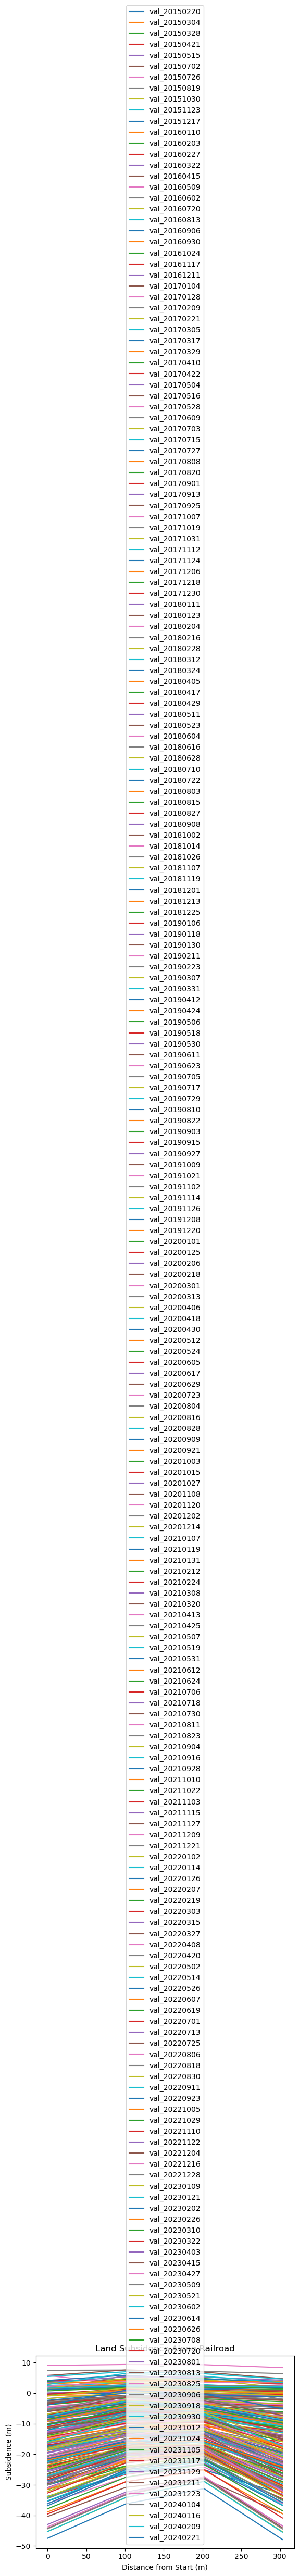

In [2]:
import matplotlib.pyplot as plt

# Plot subsidence profiles
for column in df.columns:
    if column.startswith("val_"):
        plt.plot(df["distance_from_start"], df[column], label=column)
plt.xlabel("Distance from Start (m)")
plt.ylabel("Subsidence (m)")
plt.legend()
plt.title("Land Subsidence Along Railroad")
plt.show()

In [20]:
import geopandas as gpd
import rasterio
import numpy as np
from shapely.geometry import Point
import os
import pandas as pd

# Paths
shp_path = "./metro/خط مترو.shp"
raster_dir = "./tiffs_reprojected"
output_path = "./subsidence_profile_with_xy.csv"

# Step 1: Read the shapefile
gdf = gpd.read_file(shp_path)
line = gdf.geometry.iloc[0]  # Assuming the shapefile contains a single line

# Verify CRS
print(f"Shapefile CRS: {gdf.crs}")
if not gdf.crs.is_projected:
    raise ValueError("Shapefile CRS is not projected (UTM). Please reproject to UTM.")

# Step 2: Get start and end points
start_point = line.coords[0]  # First vertex
end_point = line.coords[-1]   # Last vertex
print(f"Start Point (X, Y in UTM): {start_point}")
print(f"End Point (X, Y in UTM): {end_point}")

# Step 3: Generate points along the line at ~101m intervals
line_length = line.length
distances = np.arange(0, line_length, 101)  # 101m intervals
points = [line.interpolate(distance) for distance in distances]

# Step 4: Extract X, Y coordinates for each point
x_coords = [point.x for point in points]
y_coords = [point.y for point in points]

# Step 5: List all raster files
raster_files = [f for f in os.listdir(raster_dir) if f.endswith(".ti.geo.tif")]
raster_files.sort()  # Sort by date

# Step 6: Extract raster values for each point
results = {
    "distance_from_start": distances,
    "X_UTM": x_coords,
    "Y_UTM": y_coords
}
for raster_file in raster_files:
    date = raster_file.split(".")[0]  # Extract date (e.g., 20150220)
    with rasterio.open(os.path.join(raster_dir, raster_file)) as src:
        values = []
        for point in points:
            # Get raster value at point
            x, y = point.x, point.y
            try:
                value = next(src.sample([(x, y)]))[0]
                values.append(value if not np.isnan(value) else np.nan)
            except:
                values.append(np.nan)  # Handle cases where point is outside raster
        results[f"val_{date}"] = values

# Step 7: Create a DataFrame and save to CSV
df = pd.DataFrame(results)
df.to_csv(output_path, index=False)
print(f"Output saved to {output_path}")

# Optional: Print first few rows of the DataFrame
print("\nFirst few rows of the output:")
print(df.head())

Shapefile CRS: EPSG:32640
Start Point (X, Y in UTM): (719349.6602999996, 4024908.5347000007)
End Point (X, Y in UTM): (690679.8828999996, 4056145.2409000006)
Output saved to ./subsidence_profile_with_xy.csv

First few rows of the output:
   distance_from_start          X_UTM         Y_UTM  val_20150220  \
0                  0.0  719349.660300  4.024909e+06           0.0   
1                101.0  719255.141857  4.024944e+06           0.0   
2                202.0  719160.623414  4.024980e+06           0.0   
3                303.0  719066.104972  4.025015e+06           0.0   
4                404.0  718971.586536  4.025051e+06           0.0   

   val_20150304  val_20150328  val_20150421  val_20150515  val_20150702  \
0     -2.195996     -0.942629      1.503353      0.788563      7.239093   
1     -2.340330     -1.055412      1.610079      0.499338      7.044411   
2     -2.376158     -0.982602      1.734737      0.404129      6.990516   
3     -2.138846     -0.751948      2.370093    

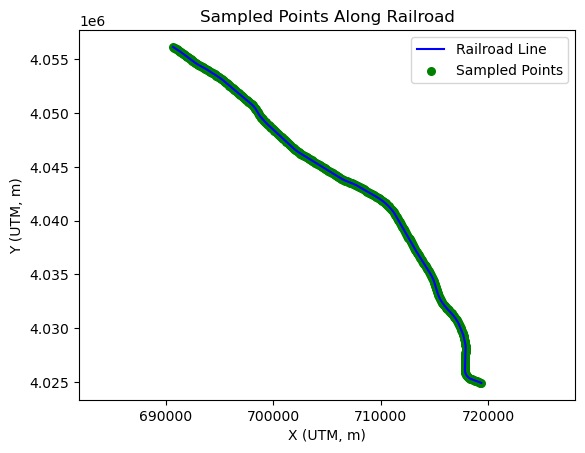

In [24]:
import matplotlib.pyplot as plt

# Plot the line and sampled points
plt.plot(*line.xy, label="Railroad Line", color="blue")
x_coords = [p.x for p in points]
y_coords = [point.y for point in points]
plt.scatter(x_coords, y_coords, color="green", label="Sampled Points", s=30)
plt.xlabel("X (UTM, m)")
plt.ylabel("Y (UTM, m)")
plt.legend()
plt.title("Sampled Points Along Railroad")
plt.axis("equal")
plt.show()

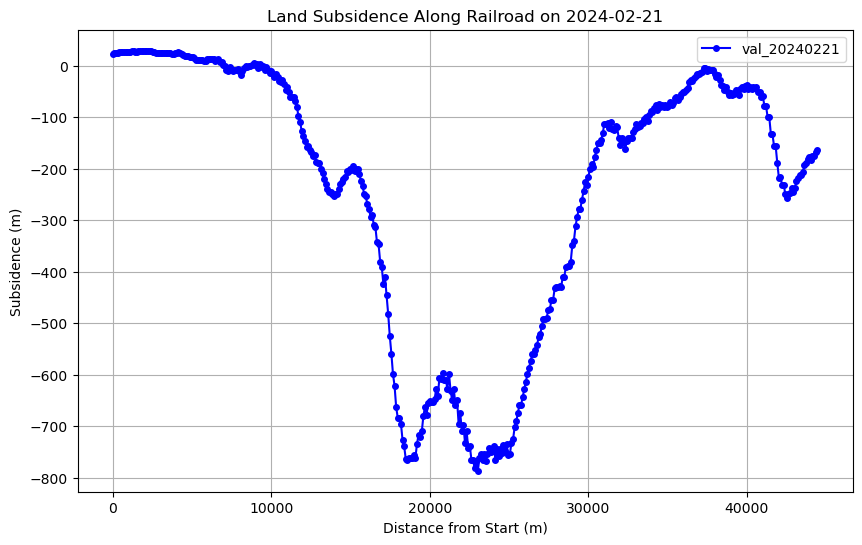

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the CSV file generated previously
csv_path = "./subsidence_profile_with_xy.csv"

# Read the CSV file
df = pd.read_csv(csv_path)

# Check if the specified column exists
target_date = "val_20240221"
if target_date not in df.columns:
    print(f"Error: Column '{target_date}' not found in the CSV. Available columns: {list(df.columns)}")
    print("Please specify a valid date column (e.g., 'val_20210823').")
else:
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df["distance_from_start"], df[target_date], label=target_date, color="blue", marker="o", markersize=4)
    plt.xlabel("Distance from Start (m)")
    plt.ylabel("Subsidence (m)")
    plt.title("Land Subsidence Along Railroad on 2024-02-21")
    plt.grid(True)
    plt.legend()
    plt.show()

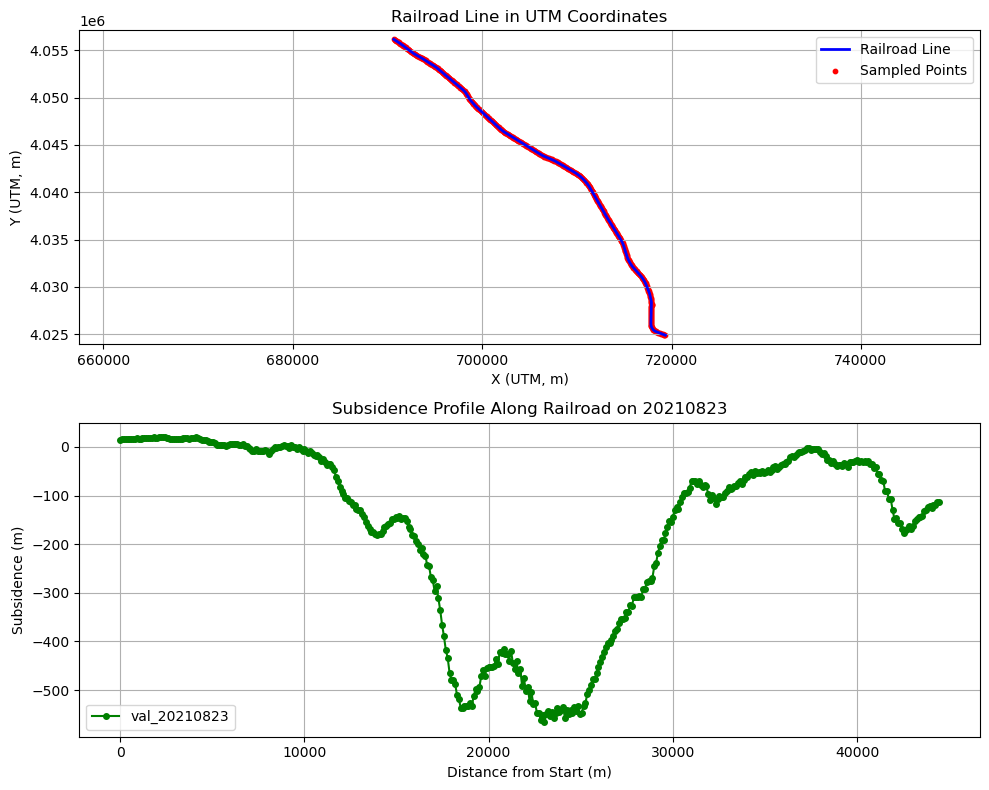

In [26]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# Paths
shp_path = "./metro/خط مترو.shp"
csv_path = "./subsidence_profile_with_xy.csv"

# Read the shapefile and CSV
gdf = gpd.read_file(shp_path)
df = pd.read_csv(csv_path)
line = gdf.geometry.iloc[0]  # Assuming single line

# Target date for subsidence profile (replace with correct date if needed)
target_date = "val_20210823"
if target_date not in df.columns:
    print(f"Error: Column '{target_date}' not found. Available columns: {list(df.columns)}")
    raise ValueError("Please specify a valid date column (e.g., 'val_20210823').")

# Create figure with two subplots (vertically stacked)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 1]})

# Top plot: Railroad line in UTM
# Plot the line
x_line, y_line = line.xy
ax1.plot(x_line, y_line, color="blue", linewidth=2, label="Railroad Line")
# Plot sampled points
ax1.scatter(df["X_UTM"], df["Y_UTM"], color="red", s=10, label="Sampled Points")
ax1.set_xlabel("X (UTM, m)")
ax1.set_ylabel("Y (UTM, m)")
ax1.set_title("Railroad Line in UTM Coordinates")
ax1.legend()
ax1.axis("equal")  # Equal scaling for X and Y
ax1.grid(True)

# Bottom plot: Subsidence profile
ax2.plot(df["distance_from_start"], df[target_date], color="green", marker="o", markersize=4, label=target_date)
ax2.set_xlabel("Distance from Start (m)")
ax2.set_ylabel("Subsidence (m)")
ax2.set_title(f"Subsidence Profile Along Railroad on {target_date.replace('val_', '')}")
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

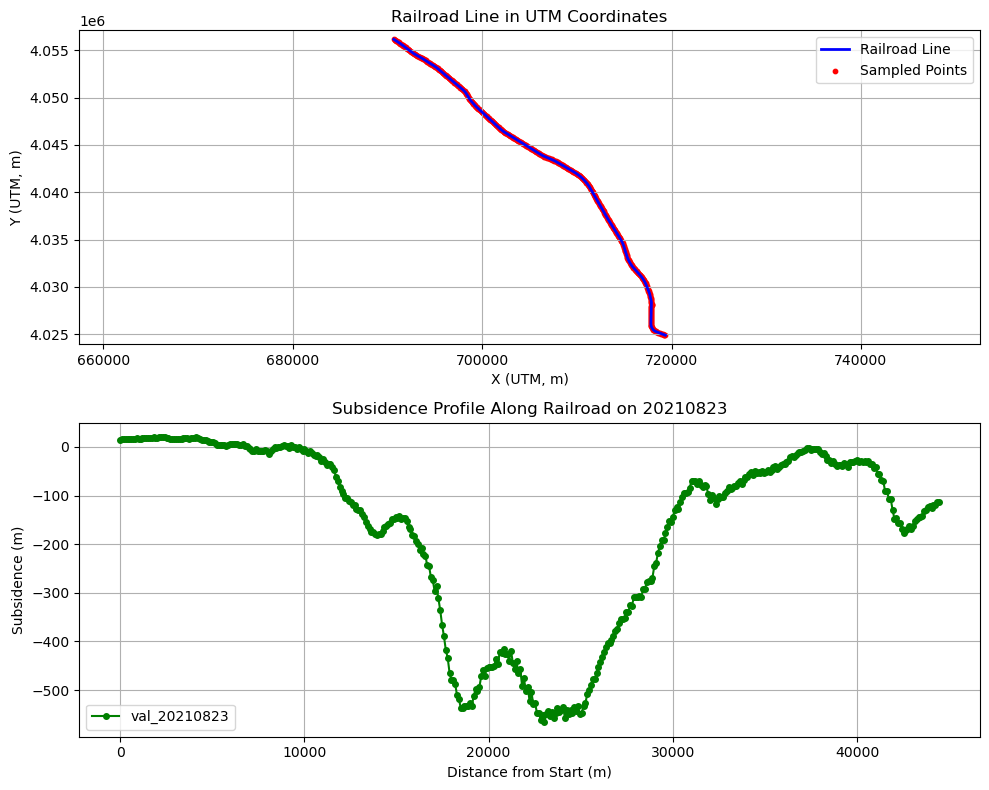

In [27]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# Paths
shp_path = "./metro/خط مترو.shp"
csv_path = "./subsidence_profile_with_xy.csv"

# Read the shapefile and CSV
gdf = gpd.read_file(shp_path)
df = pd.read_csv(csv_path)
line = gdf.geometry.iloc[0]  # Assuming single line

# Target date for subsidence profile (replace with correct date if needed)
target_date = "val_20210823"
if target_date not in df.columns:
    print(f"Error: Column '{target_date}' not found. Available columns: {list(df.columns)}")
    raise ValueError("Please specify a valid date column (e.g., 'val_20210823').")

# Create figure with two subplots (vertically stacked)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 1]})

# Top plot: Railroad line in UTM
# Plot the line
x_line, y_line = line.xy
ax1.plot(x_line, y_line, color="blue", linewidth=2, label="Railroad Line")
# Plot sampled points
ax1.scatter(df["X_UTM"], df["Y_UTM"], color="red", s=10, label="Sampled Points")
ax1.set_xlabel("X (UTM, m)")
ax1.set_ylabel("Y (UTM, m)")
ax1.set_title("Railroad Line in UTM Coordinates")
ax1.legend()
ax1.axis("equal")  # Equal scaling for X and Y
ax1.grid(True)

# Bottom plot: Subsidence profile
ax2.plot(df["distance_from_start"], df[target_date], color="green", marker="o", markersize=4, label=target_date)
ax2.set_xlabel("Distance from Start (m)")
ax2.set_ylabel("Subsidence (m)")
ax2.set_title(f"Subsidence Profile Along Railroad on {target_date.replace('val_', '')}")
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

In [1]:
import geopandas as gpd
import pandas as pd
import folium
import plotly
import plotly.graph_objs as go
import json
from jinja2 import Template
import numpy as np
import os

# Paths
shp_path = "./metro/خط مترو.shp"
csv_path = "./subsidence_profile_with_xy.csv"
output_html = "subsidence_map_plot.html"

# Read the shapefile and CSV
gdf = gpd.read_file(shp_path)
df = pd.read_csv(csv_path)
line = gdf.geometry.iloc[0]  # Assuming single line

# Reproject shapefile to WGS84 (EPSG:4326) for Folium
gdf_wgs84 = gdf.to_crs(epsg=4326)
line_wgs84 = gdf_wgs84.geometry.iloc[0]

# Create Folium map
# Center map on the line's centroid
centroid = line_wgs84.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=12, tiles="OpenStreetMap")

# Add railroad line
coords = [[point[1], point[0]] for point in line_wgs84.coords]  # [lat, lon]
folium.PolyLine(coords, color="blue", weight=4, popup="Railroad Line").add_to(m)

# Add markers every 2 km (2000 meters)
line_length = line.length  # In UTM meters
distances_2km = np.arange(0, line_length, 2000)
marker_points = [line.interpolate(d) for d in distances_2km]
marker_points_wgs84 = [gdf.to_crs(epsg=4326).geometry.iloc[0].interpolate(d / line.length, normalized=True) for d in distances_2km]
for i, point in enumerate(marker_points_wgs84):
    folium.Marker(
        location=[point.y, point.x],
        popup=f"Distance: {distances_2km[i]:.0f} m",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(m)

# Save Folium map to HTML string
folium_html = m._repr_html_()

# Prepare Plotly data for subsidence profiles
date_columns = [col for col in df.columns if col.startswith("val_")]
plotly_data = []
for date in date_columns:
    trace = go.Scatter(
        x=df["distance_from_start"],
        y=df[date],
        mode="lines+markers",
        name=date,
        marker=dict(size=4)
    )
    plotly_data.append(trace)

# HTML template
html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Railroad Subsidence Visualization</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        body { font-family: Arial, sans-serif; margin: 0; padding: 20px; }
        #map { height: 500px; margin-bottom: 20px; }
        #plot { height: 400px; }
        h1 { text-align: center; }
        .container { max-width: 1200px; margin: auto; }
    </style>
</head>
<body>
    <div class="container">
        <h1>Railroad Subsidence Visualization</h1>
        <h2>Railroad Track Map</h2>
        <div id="map">{{ folium_map }}</div>
        <h2>Subsidence Profile</h2>
        <div id="plot"></div>
    </div>

    <script>
        var data = {{ plotly_data }};
        var layout = {
            title: { text: 'Subsidence Profile Along Railroad', x: 0.5, xanchor: 'center' },
            xaxis: { title: 'Distance from Start (m)' },
            yaxis: { title: 'Subsidence (m)' },
            updatemenus: [{
                buttons: [
                    {% for date in date_columns %}
                    {
                        method: 'update',
                        label: '{{ date.replace("val_", "") }}',
                        args: [{
                            y: [data.find(d => d.name === '{{ date }}').y],
                            name: '{{ date }}'
                        }, [0]]
                    }{% if not loop.last %},{% endif %}
                    {% endfor %}
                ],
                direction: 'down',
                showactive: true,
                x: 0.1,
                xanchor: 'left',
                y: 1.2,
                yanchor: 'top'
            }],
            showlegend: true
        };
        Plotly.newPlot('plot', [data[0]], layout);
    </script>
</body>
</html>
"""

# Render and save HTML
template = Template(html_template)
with open(output_html, "w") as f:
    f.write(template.render(
        folium_map=folium_html,
        plotly_data=json.dumps([trace.to_plotly_json() for trace in plotly_data], cls=plotly.utils.PlotlyJSONEncoder),
        date_columns=date_columns
    ))

print(f"Interactive visualization saved to {output_html}")

Interactive visualization saved to subsidence_map_plot.html


In [15]:
import geopandas as gpd
import pandas as pd
import folium
import plotly.graph_objs as go
import json
from jinja2 import Template
import numpy as np
import os
import sys

# Paths
shp_path = "./metro/خط مترو.shp"
csv_path = "./subsidence_profile_with_xy.csv"
output_html = "subsidence_map_plot.html"

# HTML template
html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Railroad Subsidence Visualization</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <script src="https://unpkg.com/leaflet@1.9.4/dist/leaflet.js"></script>
    <link rel="stylesheet" href="https://unpkg.com/leaflet@1.9.4/dist/leaflet.css" />
    <style>
        body { font-family: Arial, sans-serif; margin: 0; padding: 20px; }
        #map { height: 500px; margin-bottom: 20px; }
        #plot { height: 400px; }
        h1 { text-align: center; }
        .container { max-width: 1200px; margin: auto; }
    </style>
</head>
<body>
    <div class="container">
        <h1>Railroad Subsidence Visualization</h1>
        <h2>Railroad Track Map</h2>
        <div id="map"></div>
        <h2>Subsidence Profile</h2>
        <div id="plot"></div>
    </div>

    <script>
        // Initialize Leaflet map
        var map = L.map('map').setView([{{ centroid.y|default(0) }}, {{ centroid.x|default(0) }}], 12);
        L.tileLayer('https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', {
            attribution: '© <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a>'
        }).add_to(map);

        // Add railroad line
        var lineCoords = {{ line_coords|tojson }};
        L.polyline(lineCoords, {color: 'blue', weight: 4}).addTo(map).bindPopup('Railroad Line');

        // Add 2km markers
        var markers = {{ markers|tojson }};
        markers.forEach(function(marker) {
            L.marker([marker.lat, marker.lon], {
                icon: L.icon({
                    iconUrl: 'https://unpkg.com/leaflet@1.9.4/dist/images/marker-icon.png',
                    iconSize: [25, 41],
                    iconAnchor: [12, 41]
                })
            }).addTo(map).bindPopup(marker.popup);
        });

        // Dynamic hover marker
        var hoverMarker = L.marker([{{ centroid.y|default(0) }}, {{ centroid.x|default(0) }}], {
            icon: L.divIcon({
                className: 'hover-marker',
                html: '<div style="background-color: yellow; width: 12px; height: 12px; border-radius: 50%; border: 2px solid black;"></div>',
                iconSize: [12, 12]
            })
        }).addTo(map);

        // Plotly data and coordinates
        var data = {{ plotly_data|tojson }};
        var coords = {{ coords_data|tojson }};

        // Plotly plot
        var layout = {
            title: { text: 'Subsidence Profile Along Railroad', x: 0.5, xanchor: 'center' },
            xaxis: { title: 'Distance from Start (m)' },
            yaxis: { title: 'Subsidence (m)' },
            updatemenus: [{
                buttons: [
                    {% for date in date_columns %}
                    {
                        method: 'update',
                        label: '{{ date.replace("val_", "") }}',
                        args: [{
                            y: [data.find(d => d.name === '{{ date }}').y],
                            name: '{{ date }}'
                        }, [0]]
                    }{% if not loop.last %},{% endif %}
                    {% endfor %}
                ],
                direction: 'down',
                showactive: true,
                x: 0.1,
                xanchor: 'left',
                y: 1.2,
                yanchor: 'top'
            }],
            showlegend: true
        };

        Plotly.newPlot('plot', [data[0]], layout);

        // Hover event to update marker
        document.getElementById('plot').on('plotly_hover', function(eventData) {
            var pointIndex = eventData.points[0].pointIndex;
            var coord = coords[pointIndex];
            hoverMarker.setLatLng([coord.lat, coord.lon]);
        });

        // Hide marker on unhover
        document.getElementById('plot').on('plotly_unhover', function() {
            hoverMarker.setLatLng([{{ centroid.y|default(0) }}, {{ centroid.x|default(0) }}]);
        });
    </script>
</body>
</html>
"""

try:
    # Verify file existence
    if not os.path.exists(shp_path):
        raise FileNotFoundError(f"Shapefile not found: {shp_path}")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found: {csv_path}")

    # Read the shapefile and CSV
    gdf = gpd.read_file(shp_path)
    df = pd.read_csv(csv_path)
    line = gdf.geometry.iloc[0]  # Assuming single line

    # Check CRS
    if not gdf.crs:
        raise ValueError("Shapefile has no CRS defined. Please set to UTM.")
    print(f"Shapefile CRS: {gdf.crs}")

    # Reproject shapefile to WGS84 (EPSG:4326)
    gdf_wgs84 = gdf.to_crs(epsg=4326)
    line_wgs84 = gdf_wgs84.geometry.iloc[0]

    # Convert CSV points to WGS84
    points = [gdf.to_crs(epsg=4326).geometry.iloc[0].interpolate(d / line.length, normalized=True) for d in df["distance_from_start"]]
    coords_wgs84 = [{"lat": p.y, "lon": p.x} for p in points]

    # Prepare 2km markers
    line_length = line.length  # In UTM meters
    distances_2km = np.arange(0, line_length, 2000)
    marker_points_wgs84 = [gdf.to_crs(epsg=4326).geometry.iloc[0].interpolate(d / line.length, normalized=True) for d in distances_2km]
    markers = [{"lat": p.y, "lon": p.x, "popup": f"Distance: {distances_2km[i]:.0f} m"} for i, p in enumerate(marker_points_wgs84)]

    # Prepare railroad line coordinates
    line_coords = [[point[1], point[0]] for point in line_wgs84.coords]  # [lat, lon]

    # Prepare Plotly data
    date_columns = [col for col in df.columns if col.startswith("val_")]
    if not date_columns:
        raise ValueError("No 'val_' columns found in CSV. Check data extraction.")
    print(f"Available date columns: {date_columns}")

    plotly_data = []
    for date in date_columns:
        trace = go.Scatter(
            x=df["distance_from_start"],
            y=df[date],
            mode="lines+markers",
            name=date,
            marker=dict(size=4)
        )
        plotly_data.append(trace)

    # Render HTML
    with open(output_html, "w") as f:
        f.write(Template(html_template).render(
            plotly_data=json.dumps([trace.to_plotly_json() for trace in plotly_data], cls=plotly.utils.PlotlyJSONEncoder),
            coords_data=json.dumps(coords_wgs84),
            date_columns=date_columns,
            centroid=line_wgs84.centroid,
            line_coords=json.dumps(line_coords),
            markers=json.dumps(markers)
        ))

    print(f"Interactive visualization saved to {output_html}")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    sys.exit(1)

Shapefile CRS: EPSG:32640
Available date columns: ['val_20150220', 'val_20150304', 'val_20150328', 'val_20150421', 'val_20150515', 'val_20150702', 'val_20150726', 'val_20150819', 'val_20151030', 'val_20151123', 'val_20151217', 'val_20160110', 'val_20160203', 'val_20160227', 'val_20160322', 'val_20160415', 'val_20160509', 'val_20160602', 'val_20160720', 'val_20160813', 'val_20160906', 'val_20160930', 'val_20161024', 'val_20161117', 'val_20161211', 'val_20170104', 'val_20170128', 'val_20170209', 'val_20170221', 'val_20170305', 'val_20170317', 'val_20170329', 'val_20170410', 'val_20170422', 'val_20170504', 'val_20170516', 'val_20170528', 'val_20170609', 'val_20170703', 'val_20170715', 'val_20170727', 'val_20170808', 'val_20170820', 'val_20170901', 'val_20170913', 'val_20170925', 'val_20171007', 'val_20171019', 'val_20171031', 'val_20171112', 'val_20171124', 'val_20171206', 'val_20171218', 'val_20171230', 'val_20180111', 'val_20180123', 'val_20180204', 'val_20180216', 'val_20180228', 'val_

In [ ]:
import geopandas as gpd
import requests
import time
from datetime import datetime
import pandas as pd
from typing import Tuple, List
import logging
from pathlib import Path

# --- Configure Logging ---
logging.basicConfig(
    level=logging.DEBUG,  # Changed to DEBUG for detailed output
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),  # Ensure logs go to terminal
        logging.FileHandler('debug.log')  # Save logs to file for review
    ]
)
logger = logging.getLogger(__name__)

# --- Constants ---
UTM_EPSG = 32643
WGS84_EPSG = 4326
BUFFER_WIDTH = 1000
INTERVAL_M = 100
OSM_RADIUS = 1000
OVERPASS_URLS = [
    "http://overpass-api.de/api/interpreter",
    "https://overpass.kumi.systems/api/interpreter"
]
RETRY_ATTEMPTS = 3
RETRY_DELAY = 5
REQUEST_TIMEOUT = 30
OUTPUT_DIR = Path("output")

# --- Setup Output Directory ---
OUTPUT_DIR.mkdir(exist_ok=True)

def setup_timer() -> datetime:
    logger.debug("Starting timer")
    return datetime.now()

def load_shapefile(filepath: str) -> gpd.GeoDataFrame:
    logger.debug(f"Loading shapefile: {filepath}")
    if not Path(filepath).exists():
        logger.error(f"Shapefile not found: {filepath}")
        raise FileNotFoundError(f"Shapefile not found: {filepath}")
    try:
        gdf = gpd.read_file(filepath)
        if gdf.empty:
            logger.error("Shapefile is empty")
            raise ValueError("Shapefile is empty")
        if gdf.geometry.iloc[0].geom_type != 'LineString':
            logger.error("Shapefile does not contain LineString geometry")
            raise ValueError("Shapefile must contain a LineString geometry")
        logger.debug("Shapefile loaded successfully")
        return gdf
    except Exception as e:
        logger.error(f"Error loading shapefile: {e}")
        raise

def reproject_to_utm(gdf: gpd.GeoDataFrame, epsg: int) -> gpd.GeoDataFrame:
    logger.debug(f"Current CRS: {gdf.crs}")
    if gdf.crs.to_epsg() != epsg:
        logger.info(f"Reprojecting to EPSG:{epsg}")
        gdf = gdf.to_crs(epsg=epsg)
    logger.debug(f"Reprojected CRS: {gdf.crs}")
    return gdf

def generate_points_along_line(line, interval_m: float = INTERVAL_M) -> Tuple[List, List]:
    logger.debug("Generating points along line")
    points, distances = [], []
    length = line.length
    steps = int(length // interval_m) + 1
    logger.debug(f"Line length: {length}m, Steps: {steps}")
    for i in range(steps):
        dist = i * interval_m
        points.append(line.interpolate(dist))
        distances.append(dist)
    logger.debug(f"Generated {len(points)} points")
    return points, distances

def create_buffer_gdf(points: List, distances: List, gdf_crs, buffer_width: float = BUFFER_WIDTH) -> gpd.GeoDataFrame:
    logger.debug("Creating buffer GeoDataFrame")
    points_gdf = gpd.GeoDataFrame({'distance_m': distances}, geometry=points, crs=gdf_crs)
    buffers = points_gdf.buffer(buffer_width / 2)
    buffer_centroids = buffers.centroid
    logger.debug(f"Created {len(buffer_centroids)} buffer centroids")
    return gpd.GeoDataFrame({'distance_m': distances}, geometry=buffer_centroids, crs=gdf_crs)

def build_overpass_query(lat: float, lon: float, radius: float = OSM_RADIUS) -> str:
    logger.debug(f"Building Overpass query for ({lat}, {lon})")
    return f"""
    [out:json];
    (
      node["place"~"village|hamlet|town"](around:{radius},{lat},{lon});
      way["natural"="water"](around:{radius},{lat},{lon});
      way["waterway"="river"](around:{radius},{lat},{lon});
      relation["natural"="water"](around:{radius},{lat},{lon});
      way["highway"](around:{radius},{lat},{lon});
      way["leisure"~"park|garden"](around:{radius},{lat},{lon});
      way["landuse"="grass"](around:{radius},{lat},{lon});
    );
    out center;
    """

def query_osm_features(point, radius: float = OSM_RADIUS) -> List[str]:
    lat, lon = point.y, point.x
    logger.debug(f"Querying OSM for point ({lat}, {lon})")
    for url_idx, overpass_url in enumerate(OVERPASS_URLS):
        logger.debug(f"Using Overpass server: {overpass_url}")
        for attempt in range(RETRY_ATTEMPTS):
            try:
                query = build_overpass_query(lat, lon, radius)
                response = requests.get(overpass_url, params={'data': query}, timeout=REQUEST_TIMEOUT)
                logger.debug(f"Response status: {response.status_code}")
                time.sleep(RETRY_DELAY)
                if response.status_code == 502:
                    logger.warning(f"Attempt {attempt + 1} failed with status 502 at ({lat}, {lon})")
                    continue
                if response.status_code != 200:
                    logger.warning(f"Attempt {attempt + 1} failed with status {response.status_code} at ({lat}, {lon})")
                    continue
                data = response.json()
                features = []
                for el in data.get('elements', []):
                    tags = el.get('tags', {})
                    name = tags.get('name', 'Unnamed')
                    if 'place' in tags:
                        features.append(f"Place: {name}")
                    elif tags.get('waterway') == 'river':
                        features.append(f"River: {name}")
                    elif tags.get('natural') == 'water':
                        features.append(f"Water body: {name}")
                    elif tags.get('highway'):
                        features.append(f"Road: {name}")
                    elif tags.get('leisure') in ['park', 'garden']:
                        features.append(f"{tags['leisure'].capitalize()}: {name}")
                    elif tags.get('landuse') == 'grass':
                        features.append(f"Green area: {name}")
                logger.debug(f"Found {len(features)} features for point ({lat}, {lon})")
                return features if features else ["None"]
            except Exception as e:
                logger.warning(f"Attempt {attempt + 1} failed at ({lat}, {lon}) using {overpass_url}: {e}")
                if attempt == RETRY_ATTEMPTS - 1 and url_idx == len(OVERPASS_URLS) - 1:
                    logger.error(f"Exhausted retries for point ({lat}, {lon})")
                    return [f"[Error] Failed after {RETRY_ATTEMPTS} attempts: {e}"]
    logger.error(f"All servers failed for point ({lat}, {lon})")
    return ["[Error] All servers failed"]

def sequential_osm_queries(points_gdf: gpd.GeoDataFrame) -> List:
    logger.debug(f"Starting sequential OSM queries for {len(points_gdf)} points")
    features_list = []
    for idx, row in points_gdf.iterrows():
        logger.debug(f"Processing point {idx + 1}/{len(points_gdf)}")
        features = query_osm_features(row.geometry)
        features_list.append("; ".join(features))
        # Save partial results every 10 points to avoid data loss
        if (idx + 1) % 10 == 0:
            logger.debug(f"Saving partial results at point {idx + 1}")
            temp_gdf = gpd.GeoDataFrame(
                {'distance_m': points_gdf['distance_m'][:len(features_list)], 'features_nearby': features_list},
                geometry=points_gdf.geometry[:len(features_list)],
                crs=points_gdf.crs
            )
            temp_gdf.to_file(OUTPUT_DIR / 'partial_results.geojson', driver='GeoJSON')
    return features_list

def save_outputs(gdf: gpd.GeoDataFrame, geojson_file: str, csv_file: str) -> None:
    logger.debug("Saving outputs")
    try:
        gdf.to_file(geojson_file, driver='GeoJSON')
        gdf[['distance_m', 'features_nearby']].to_csv(csv_file, index=False, encoding='utf-8-sig')
        logger.info(f"Saved outputs to {geojson_file} and {csv_file}")
    except Exception as e:
        logger.error(f"Error saving outputs: {e}")
        raise

def main():
    start_time = setup_timer()
    try:
        logger.debug("Starting main function")
        route_fp = 'خط مترو.shp'
        route_gdf = load_shapefile(route_fp)
        route_gdf = reproject_to_utm(route_gdf, UTM_EPSG)
        route_line = route_gdf.geometry.iloc[0]
        points, distances = generate_points_along_line(route_line)
        buffers_gdf = create_buffer_gdf(points, distances, route_gdf.crs)
        buffers_wgs = buffers_gdf.to_crs(epsg=WGS84_EPSG)
        logger.info("Starting OSM queries...")
        features_list = sequential_osm_queries(buffers_wgs)
        points_gdf = gpd.GeoDataFrame(
            {'distance_m': distances, 'features_nearby': features_list},
            geometry=points,
            crs=route_gdf.crs
        )
        geojson_output = OUTPUT_DIR / 'train_route_100m_linearbuffer.geojson'
        csv_output = OUTPUT_DIR / 'train_route_100m_linearbuffer.csv'
        save_outputs(points_gdf, geojson_output, csv_output)
        logger.info("\nResults:")
        logger.info(points_gdf[['distance_m', 'features_nearby']].to_string())
        logger.info(f"\n✔️ Done! Total runtime: {datetime.now() - start_time}")
    except Exception as e:
        logger.error(f"Main function failed: {e}")
        raise

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        logger.error(f"Script failed: {e}")
        raise